**NOTE:** We are using the Julia 1.9.2 Kernel for this workbook.

In [1]:

# import Pkg
# Pkg.add("HDF5")
# Pkg.add("JSON")
# Pkg.add("Plots")
# Pkg.add("GraphicalModelLearning")

using HDF5
using JSON
using Plots

using GraphicalModelLearning #GML
# GML from Los Alamos National Laboratory
# https://github.com/lanl-ansi/GraphicalModelLearning.jl

# Benchmark Workflow

The *benchmark performer* shall:
1. Select an `instance.<uuid-x>.json` file from the `benchmark_instances` directory.
2. Generate samples from the instance using their method and hardware of choice.  The `instance.<uuid-x>.json` file includes the appropriate time limit and number of samples $k$ to generate.
3. Write the samples they generated to `solution.<uuid-y>.hdf5` file in the `benchmark_performer_submissions` folder.  Metadata fields inside of the `solution.<uuid-y>.hdf5` reference the original `instance.<uuid-x>.json` file and UUID.


The *benchmark proctor* shall:
1. Select a `solution.<uuid-y>.hdf5` file and perform verification that the $k$ samples were accurately drawn from the system of interest.
2. Write out performance metrics to a `performance_metrics.<uuid-z>.json` file in the `benchmark_performance_metrics` directory.


Optionally:  a script will parse `performance_metrics.*.json` files in the `benchmark_performance_metrics` directory and present summary statistics, plots, etc.




In [2]:
# Acting as the Benchmark Proctor
#
# Fetch the solution.<uuid-y>.h5 file the benchmark performer submitted


# fixed filename/UUID for this example:
filename = "../benchmark_performer_submissions/solution.ee69de1e-3620-11ee-be05-8f4ea6fc831a.h5"
instance_uuid = HDF5.h5read(filename, "solution/instance_uuid") # original test instance
solution_uuid = HDF5.h5read(filename, "solution/solution_uuid") # solution submitted by performer
println("Benchmark Performer Submitted Solution UUID:",solution_uuid)

solution = HDF5.h5read(filename, "solution");
counts = solution["solution_reported"]["states_observed_counts"];
states = solution["solution_reported"]["states_observed"]

# first column is number of observations (counts).  
# we organize the samples in this way for compatibility with the GraphicalModelLearning package.
samples = hcat(counts, transpose(states));


Benchmark Performer Submitted Solution UUID:ee69de1e-3620-11ee-be05-8f4ea6fc831a


In [4]:
# Acting as the Benchmark Proctor
#
# Read in the adjacency matrix and external field from the ORIGINAL instance.<uuid-x>.json field


# fixed filename/UUID for this example:
filename = "../benchmark_instances/instance." * instance_uuid * ".EXAMPLE.json"
graph_data = JSON.parsefile(filename)["graph_data"]

n = length(graph_data["nodes"])

interaction_strength_J = zeros(n,n)


# reassemble interaction_strength_J matrix from dictionary:
for edge in graph_data["links"]
    i = edge["source"] + 1 # plus 1 because we are going rom base0 to base1
    j = edge["target"] + 1
    w = edge["weight"]
    interaction_strength_J[i,j] = w
    interaction_strength_J[j,i] = w
end

external_field_B = zeros(n)
for node in graph_data["nodes"]
    i = node["id"] + 1 # plus 1 because we are going from base0 to base1
    external_field_B[i] = node["B"]
end


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



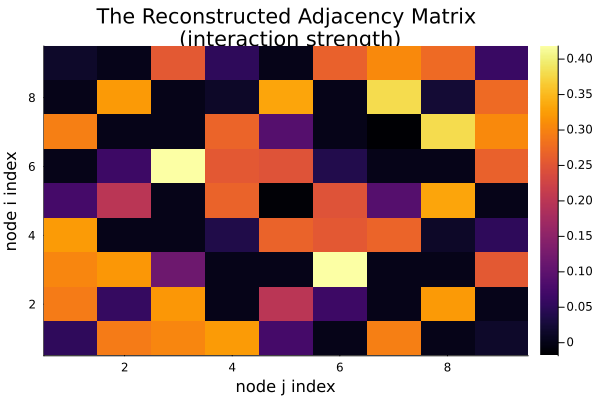

In [5]:
# Acting as the Benchmark Proctor
#
# Use the GraphicalModelLearning package to estimate 
# the original graph parameters and topology using 
# only the samples submitted by the benchmark performer.


# The output is in the form of an adjacency matrix for the original graph.
# TODO:  what about the individual external field terms???
learned_adj_matrix = learn(
    samples,
    GraphicalModelLearning.RISE(),
    GraphicalModelLearning.NLP()
)


gr()
heatmap(learned_adj_matrix)
title!("The Reconstructed Adjacency Matrix\n (interaction strength)")
xlabel!("node j index")
ylabel!("node i index")

# TODO: note: the samples account for the external_field_B

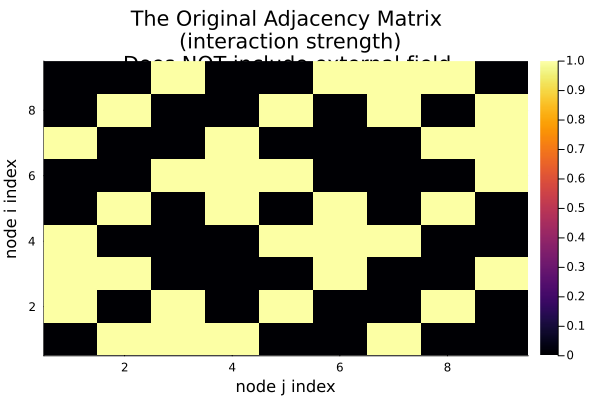

In [6]:


heatmap(interaction_strength_J)
title!("The Original Adjacency Matrix\n (interaction strength)\n Does NOT include external field.")
xlabel!("node j index")
ylabel!("node i index")

# TODO: note: the original interaction_strength_J matrix does NOT account for external field.


In [ ]:


# TODO: calculate average time per sample.  including number of CPUs used if parallelized.  


# TODO: factor in the k_B and system temperature


